## Import Necessary Packages

In [1]:
import glob
import numpy as np
import xarray as xr
import metpy.calc as mp
from scipy import interpolate
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

## Define Common Variables and Functions

In [2]:
months = ['June','July','August']
names  = ['TRMM (1998 - 2013)','IMERG (2000 - 2020)','ERA5 (1959 - 2021)']
colors = np.asarray(['#F18F01','#7EA43D','#006E90'])
lights = np.asarray(['#FEDEAE','#DBE9C3','#ADECFF'])

In [3]:
def varclimo(vardata):
    regionaldata = vardata.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2))
    databymonth = regionaldata.groupby('time.month').mean('time',keep_attrs=True)
    return databymonth
def varprofile(vardata):
    lonslice = vardata.lon.sel(lon=slice(lon1,lon2)).to_numpy()
    varslice = vardata.sel(lon=slice(lon1,lon2),lat=slice(lat1,lat2)).mean(dim='lat').to_numpy()
    transform = interpolate.interp1d(lonslice,varslice,bounds_error=False)
    data = xr.DataArray(transform(e3sm.lon.sel(lon=slice(lon1,lon2)))).rename({'dim_0':'year','dim_1':'lon'})
    databymonth = xr.concat((data[0::3],data[1::3],data[2::3]),dim='month')
    return databymonth
def formatpr(databymonth):
    totalpr = xr.concat((databymonth[0]*30,databymonth[1]*31,databymonth[2]*31),dim='month')
    return totalpr
def meanstd(vardata,dim):
    mean = vardata.mean(dim=dim)
    std = vardata.std(dim=dim)
    return mean,std
def normalize(vardata):
    return (vardata - np.min(vardata))/(np.max(vardata)-np.min(vardata))

## Figure 1

In [4]:
path = '/ocean/projects/atm200007p/sferrett/'
e3sm = np.squeeze(xr.open_dataset(path+'e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
era5 = xr.merge((xr.open_dataset(path+'era5/ERA5_3D_195906_202108_monthly.nc'),
                 xr.open_dataset(path+'era5/ERA5_2D_195906_202108_monthly.nc')),compat='override')
era5 = era5.reindex(latitude=era5.latitude[::-1]).reindex(level=era5.level[::-1]).rename({'longitude':'lon','latitude':'lat'})

In [5]:
lat1=5; lat2=25; lon1=55; lon2=90
x,y = np.meshgrid(era5.lon[::10].sel(lon=slice(lon1,lon2)),era5.lat[::10].sel(lat=slice(lat1,lat2)))
u,v = varclimo(era5.u[:,6,::10,::10]),varclimo(era5.v[:,6,::10,::10])
pr  = formatpr(varclimo(era5.mtpr*86400))

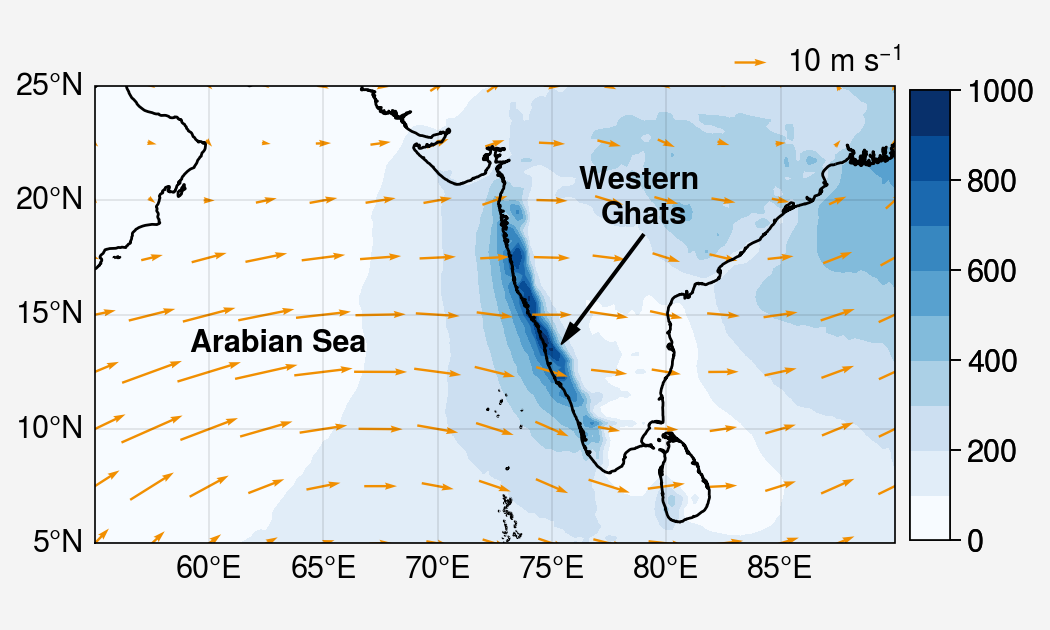

In [6]:
pplt.rc.reso = 'hi'; pplt.rc.update({'font.size':11}); style = dict(color='k',ha='center',weight='bold')
fig,ax = pplt.subplots(nrows=1,ncols=1,refwidth=4,refheight=3,proj='cyl')
ax.format(lonlim=(lon1,lon2),lonlines=5,lonlabels='b',
          latlim=(lat1,lat2),latlines=5,latlabels='l',
          land=False,coast=True,coastcolor='k',coastlinewidth=1)
ax.text(79,19,'Western \nGhats',**style)
ax.text(63,13.4,'Arabian Sea',**style)
ax.arrow(79,18.5,-3,-4,width=0.1,head_width=0.5,head_length=1,facecolor='k')
m = ax.contourf(pr.mean(dim='month'),levels=10,cmap='Blues')
q = ax.quiver(x,y,u.mean(dim='month'),v.mean(dim='month'),color=colors[0],scale=250,pivot='middle',width=0.003)
ax.colorbar(m,loc='r',length=0.75,ticks=200,label='')
ax.quiverkey(q,0.73,0.9,10,label=r'10 m s$^{-1}$',labelpos='E',coordinates='figure')

## Figure 2

In [7]:
path  = '/ocean/projects/atm200007p/sferrett/'
e3sm  = np.squeeze(xr.open_mfdataset(path+'e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc')).drop_dims('nbnd').drop(('time','area'))
trmm  = xr.open_mfdataset(np.sort(glob.glob(path+'trmm/*_0[6-8]_*climo.nc')))
imerg = xr.open_mfdataset(np.sort(glob.glob(path+'imerg/*_0[6-8]_*climo.nc*'))).transpose('time','lat','lon')
era5  = xr.open_dataset(path+'era5/ERA5_2D_195906_202108_monthly.nc')
era5  = era5.reindex(latitude=era5.latitude[::-1]).rename({'latitude':'lat','longitude':'lon'})

In [8]:
lat1=7; lat2=23; lon1=60; lon2=90
trmmpr  = formatpr(varclimo(trmm.pr*86400))
imergpr = formatpr(varclimo(imerg.precipitation*24))
era5pr  = formatpr(varclimo(era5.mtpr*86400))

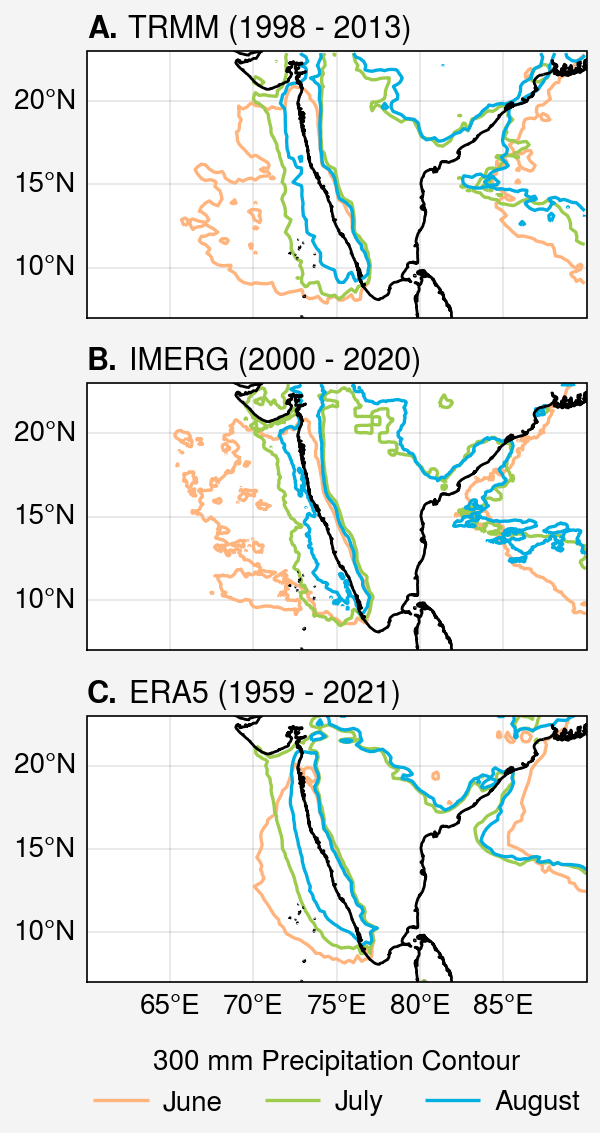

In [9]:
pplt.rc.reso = 'hi'; pplt.rc.update({'font.size':10}); style=dict(levels=[300],linewidth=1.2); key=[]
fig,axs = pplt.subplots(ncols=1,nrows=3,proj='cyl',sharex=True,sharey=True)
axs.format(lonlim=(lon1,lon2),lonlines=5,latlim=(lat1,lat2),latlines=5,latlabels=True,
           land=False,coast=True,coastcolor='k',coastlinewidth=1,abc='A.',abcloc='l',titleloc='l')
axs[2].format(lonlabels=True)
for i,month in enumerate(months):   
    maps = axs[0].contour(trmmpr[i],cmap=colors[i],**style)
    axs[1].contour(imergpr[i],cmap=colors[i],**style)
    axs[2].contour(era5pr[i],cmap=colors[i],**style)
    key.append(maps)
    axs[i].format(title=names[i])
C1=key[0].legend_elements()[0][0]; C2=key[1].legend_elements()[0][0]; C3=key[2].legend_elements()[0][0]
fig.legend([C1,C2,C3],['June','July','August'],loc='b',ncols=3,frame=False,title='300 mm Precipitation Contour')

## Figure 3 (Extra)

In [10]:
path  = '/ocean/projects/atm200007p/'
e3sm  = np.squeeze(xr.open_dataset(path+'sferrett/e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
imerg = xr.open_mfdataset(np.sort(glob.glob(path+'nanaliu/imerg/'+'*.nc4'))).transpose('time','lat','lon')
era5  = xr.open_dataset(path+'sferrett/era5/ERA5_2D_195906_202108_monthly.nc')
era5  = era5.reindex(latitude=era5.latitude[::-1]).rename({'longitude':'lon','latitude':'lat'})

In [11]:
lat1=10; lat2=20; lon1=55; lon2=85; years=63
z   = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/9.80665/1000
lon = e3sm.lon.sel(lon=slice(lon1,lon2))
pr  = formatpr(varprofile(era5.mtpr*86400))
prmean,prstd = meanstd(pr,'year')

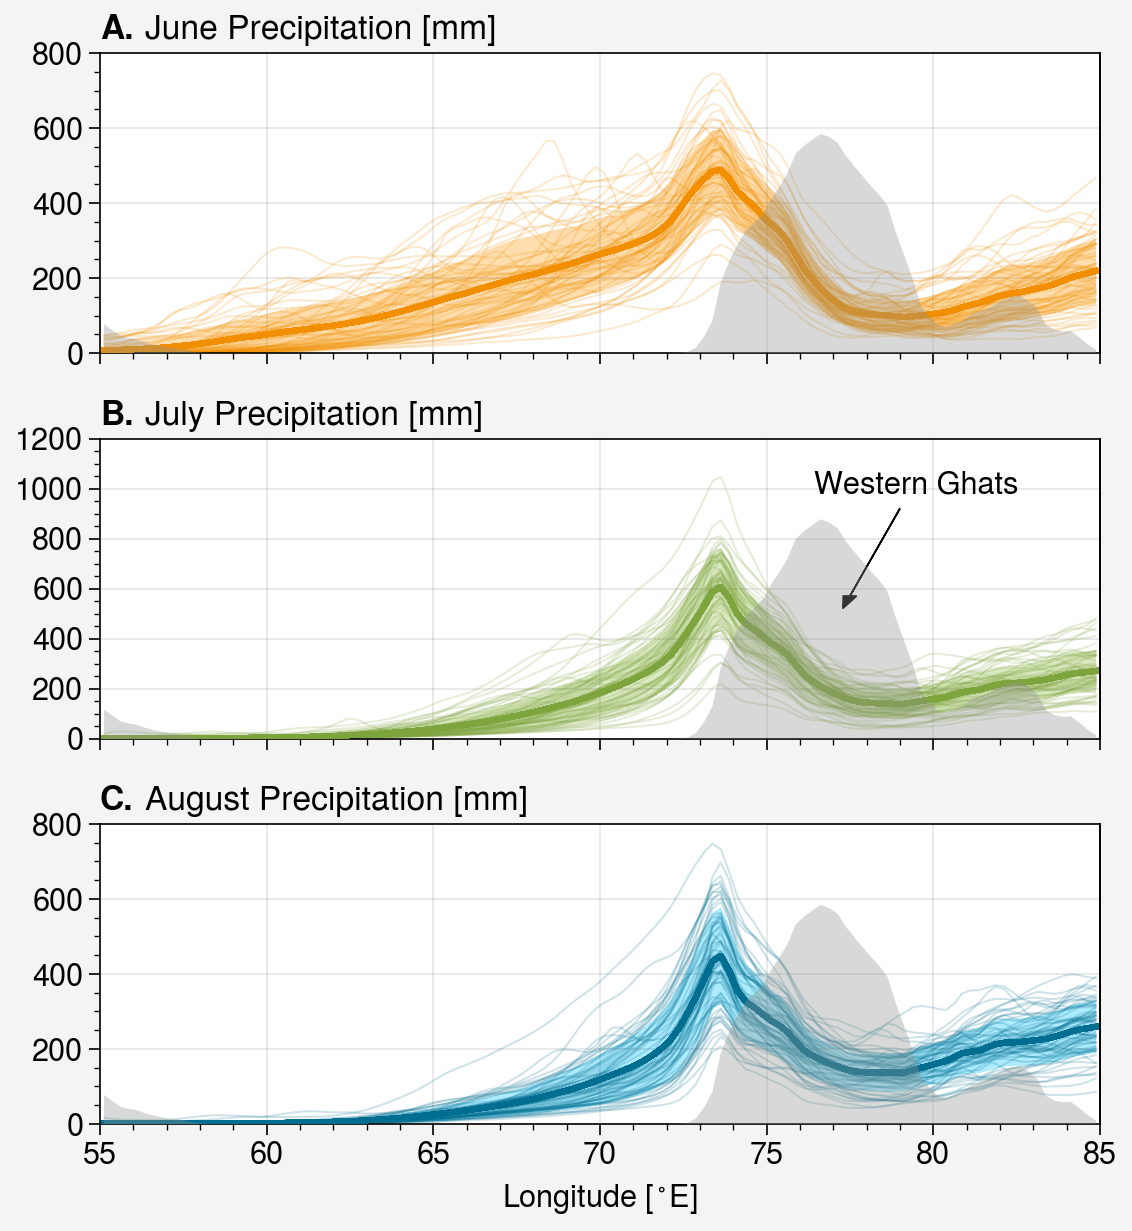

In [12]:
pplt.rc.reso = 'hi'; pplt.rc.update({'font.size':11})
fig,axs = pplt.subplots(ncols=1,nrows=3,refwidth=5,refheight=1.5)
axs.format(xlabel='Longitude [$^\circ$E]',xlim=(lon1,lon2),xticks=5,
           abc='A.',abcloc='l',titleloc='l')
axs[0].format(ylim=(0,800),yticks=200)
axs[1].format(ylim=(0,1200),yticks=200)
axs[2].format(ylim=(0,800),yticks=200)
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylabel='',ylim=(0,0.8),yticks='null')
for i,ax in enumerate(months): 
    for j in range(years):
        axs[i].fill_between(lon,prmean[i]-prstd[i],prmean[i]+prstd[i],facecolor=lights[i],alpha=0.1,zorder=1)
        axs[i].plot(lon,pr[i,j],colors=colors[i],linewidth=0.7,alpha=0.2,zorder=2)
        axs[i].plot(lon,prmean[i],colors=colors[i],linewidth=2,zorder=3)
        axs[i].format(title=str(months[i])+' Precipitation [mm]')
axs[1].text(79.5,980,'Western Ghats',color='k',ha='center')
axs[1].arrow(79,920,-1.5,-350,head_width=0.4,head_length=50,facecolor='k')

## Figure 4

In [13]:
path = '/ocean/projects/atm200007p/sferrett/'
e3sm = np.squeeze(xr.open_dataset(path+'e3sm/E3SM_ANN_000101_000312_climo_PRECL_PRECC_PHIS.nc'))
era5 = xr.merge((xr.open_dataset(path+'era5/ERA5_3D_195906_202108_monthly.nc'),
                 xr.open_dataset(path+'era5/ERA5_2D_195906_202108_monthly.nc')),compat='override')
era5 = era5.reindex(latitude=era5.latitude[::-1]).reindex(level=era5.level[::-1]).rename({'longitude':'lon','latitude':'lat'})

In [14]:
lat1=10; lat2=20; lon1=55; lon2=85; 
era5 = era5.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).sel(level=slice(1000,50))
z   = e3sm.PHIS.sel(lat=slice(lat1,lat2),lon=slice(lon1,lon2)).mean(dim='lat')/9.80665/1000
lon = e3sm.lon.sel(lon=slice(lon1,lon2))

In [15]:
a=1; b=a; rho=1.204; g=9.80665
Td  = mp.dewpoint_from_specific_humidity(era5.level,era5.t,era5.q)
Te  = mp.equivalent_potential_temperature(era5.level,era5.t,Td)
Tes = mp.saturation_equivalent_potential_temperature(era5.level,era5.t)
bottom = era5.level[0]        
del_pB = era5.level.sel(level=((rho*9.80665*(era5.blh))/100),method='nearest')
split  = era5.level.sel(level=(bottom-del_pB),method='nearest')
top    = era5.level.where(era5.t>273.16).min(dim='level')
del_pL = split-top
wB = ((a*del_pB)/(b*del_pL))*np.log((a*del_pB+b*del_pL)/(a*del_pB))
wL = 1-wB
TeB  = Te.where(Te.level>=split).dropna(dim='level').mean(dim='level')
TeL  = Te.where((Te.level<=split)&(Te.level>=top)).dropna(dim='level').mean('level')
TesL = Tes.where((Tes.level<=split)&(Tes.level>=top)).dropna(dim='level').mean('level')
BL   = (g*(wB*((TeB-TesL)/TesL)-wL*((TesL-TeL)/TesL)))

In [16]:
v850 = varprofile(np.sqrt(era5.u[:,6]**2+era5.v[:,6]**2))
bl   = varprofile(BL)
pr   = formatpr(varprofile(era5.mtpr*86400))
v850mean,v850std = meanstd(v850,'year')
blmean,blstd = meanstd(bl,'year')
prmean,prstd = meanstd(pr,'year')
v850norm,(v850normmean,v850normstd) = normalize(v850),meanstd(normalize(v850),'year')
blnorm,(blnormmean,blnormstd) = normalize(bl),meanstd(normalize(bl),'year')
prnorm,(prnormmean,prnormstd) = normalize(pr),meanstd(normalize(pr),'year')

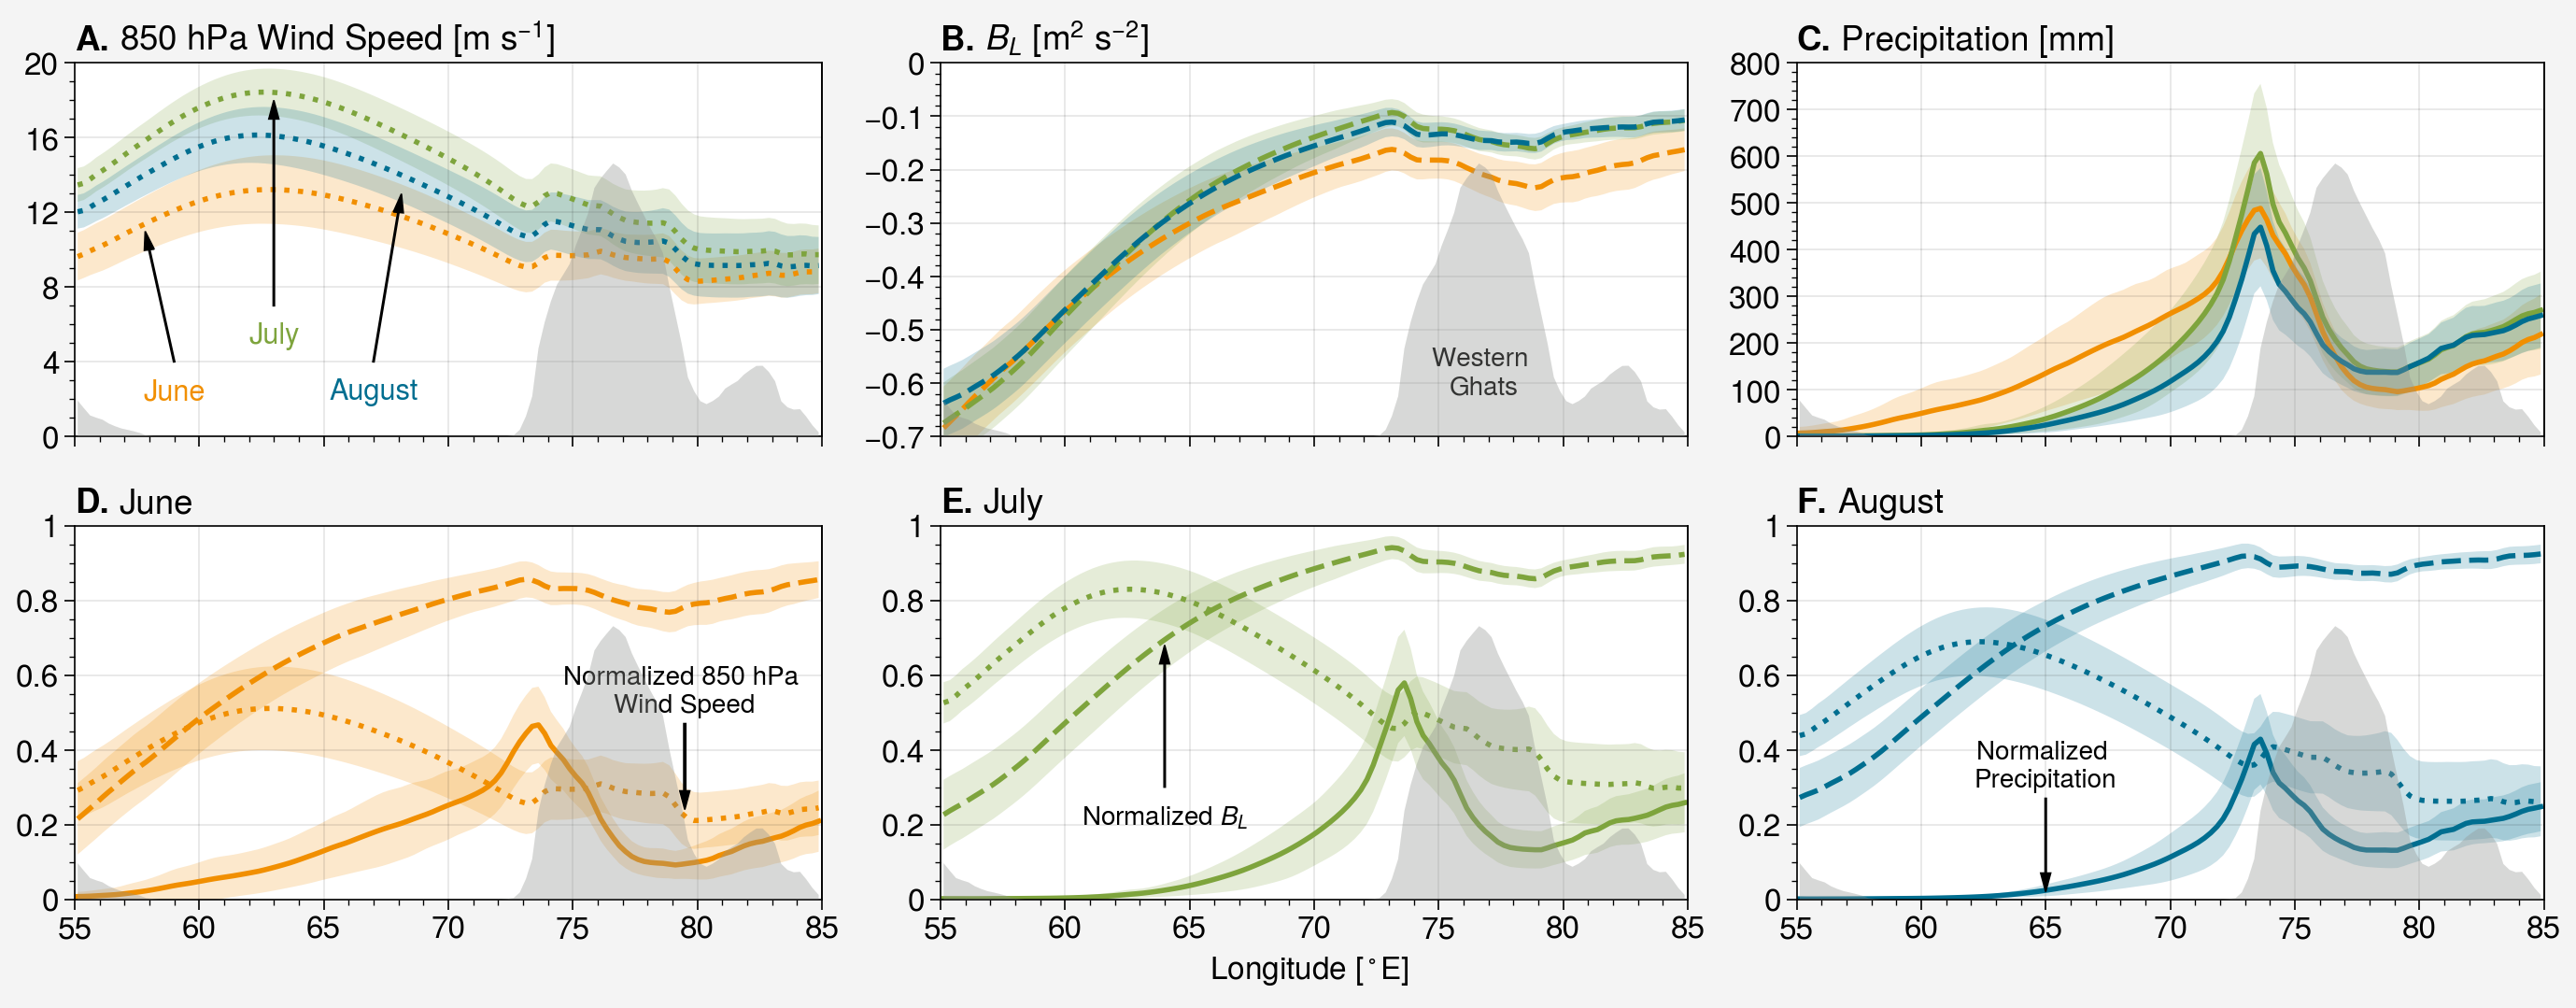

In [151]:
pplt.rc.reso = 'hi'; pplt.rc.update({'font.size':12})
shadestyle=dict(alpha=0.2,zorder=1); linestyle=dict(linewidth=2,zorder=2) 
fig,axs = pplt.subplots(ncols=3,nrows=2,refwidth=4,refheight=2,sharey=False)
axs.format(xlabel='Longitude [$^\circ$E]',xlim=(lon1,lon2),xticks=5,abc='A.',abcloc='l',titleloc='l')
axs[0].format(ylim=(0,20),yticks=4,title='850 hPa Wind Speed [m s$^{-1}$]')
axs[1].format(ylim=(-0.7,-0),yticks=0.1,title='$\mathit{B_L}$ [m$^2$ s$^{-2}$]')
axs[2].format(ylim=(0,800),yticks=100,title='Precipitation [mm]')
axs[3].format(ylim=(0,1),yticks=0.2,title='June (Normalized)')
axs[4].format(ylim=(0,1),yticks=0.2,title='July (Normalized)')
axs[5].format(ylim=(0,1),yticks=0.2,title='August (Normalized)')
oxs = axs.twinx()
oxs.fill_between(lon,z,fc='grey',alpha=0.2,zorder=0)
oxs.format(ylabel='',ylim=(0,0.8),yticks='null')
for i,month in enumerate(months):
    axs[0].fill_between(lon,v850mean[i]-v850std[i],v850mean[i]+v850std[i],fc=colors[i],**shadestyle)
    axs[0].plot(lon,v850[i].mean(dim='year'),colors=colors[i],linestyle='dotted',**linestyle)
    axs[1].fill_between(lon,blmean[i]-blstd[i],blmean[i]+blstd[i],fc=colors[i],**shadestyle)
    axs[1].plot(lon,bl[i].mean(dim='year'),colors=colors[i],linestyle='dashed',**linestyle)
    axs[2].fill_between(lon,prmean[i]-prstd[i],prmean[i]+prstd[i],fc=colors[i],**shadestyle)
    lines = axs[2].plot(lon,pr[i].mean(dim='year'),colors=colors[i],linestyle='solid',**linestyle)
    key.append(lines) 
    axs[i+3].fill_between(lon,v850normmean[i]-v850normstd[i],v850normmean[i]+v850normstd[i],fc=colors[i],**shadestyle)
    win = axs[i+3].plot(lon,v850normmean[i],colors=colors[i],linestyle='dotted',**linestyle)
    axs[i+3].fill_between(lon,blnormmean[i]-blnormstd[i],blnormmean[i]+blnormstd[i],fc=colors[i],**shadestyle)
    var = axs[i+3].plot(lon,blnormmean[i],colors=colors[i],linestyle='dashed',**linestyle)
    axs[i+3].fill_between(lon,prnormmean[i]-prnormstd[i],prnormmean[i]+prnormstd[i],fc=colors[i],**shadestyle)
    pre = axs[i+3].plot(lon,prnormmean[i],colors=colors[i],linestyle='solid',**linestyle)
    axs[i+3].format(title=months[i])
axs[0].text(59,2,'June',ha='center',size=11,color=colors[0])
axs[0].text(63,5,'July',ha='center',size=11,color=colors[1])
axs[0].text(67,2,'August',ha='center',size=11,color=colors[2])
axs[0].arrow(59,4,-1,6,color='k',width=0.05,head_width=0.4,head_length=1,zorder=4)
axs[0].arrow(63,7,0,10,color='k',width=0.05,head_width=0.4,head_length=1,zorder=4)
axs[0].arrow(67,4,1,8,color='k',width=0.05,head_width=0.4,head_length=1,zorder=4)
axs[1].text(76.8,-0.62,'Western \nGhats',ha='center',size=10,color='k')
axs[3].text(79.5,0.5,'Normalized 850 hPa \nWind Speed',ha='center',size=10,color='k')
axs[4].text(64,0.2,'Normalized $\mathit{B_L}$',ha='center',size=10,color='k')
axs[5].text(65,0.3,'Normalized \nPrecipitation',ha='center',size=10,color='k')
axs[3].arrow(79.5,0.47,0,-0.18,width=0.08,head_width=0.4,head_length=0.05,color='k',zorder=4)
axs[4].arrow(64,0.3,0,0.33,color='k',width=0.05,head_width=0.4,head_length=0.05,zorder=4)
axs[5].arrow(65,0.27,0,-0.2,color='k',width=0.05,head_width=0.4,head_length=0.05,zorder=4)

## Figure 5

(<matplotlib.legend.Legend at 0x155312834f70>,
 <matplotlib.legend.Legend at 0x155312840c40>)

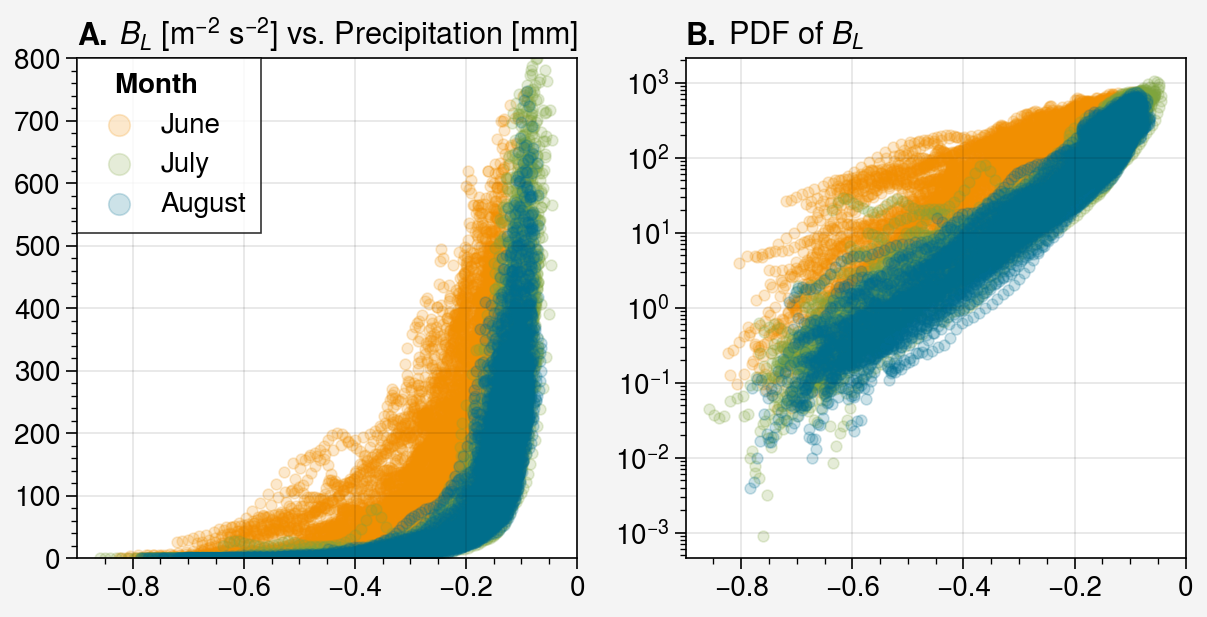

In [152]:
pplt.rc.reso='hi'; pplt.rc.update({'font.size':10}); style=dict(s=15,marker='o',alpha=0.2); key=[]
fig,axs = pplt.subplots(ncols=2,nrows=1,refheight=2.5,sharex=True,sharey=False)
axs.format(xlim=(-0.9,0),xticks=0.2,abc='A.',abcloc='l',titleloc='l')
axs[0].format(title='$\mathit{B_L}$ [m$^{-2}$ s$^{-2}$] vs. Precipitation [mm]',ylim=(0,800),yticks=100)
axs[1].format(title='PDF of $\mathit{B_L}$',yscale='log',yformatter='log')
for i,month in enumerate(months):                       
    dots = axs[0].scatter(bl[i],pr[i],colors=colors[i],**style)
    axs[1].scatter(bl[i],pr[i],colors=colors[i],**style)
    key.append(dots)
C1=key[0]; C2=key[1]; C3=key[2]    
axs[0].legend(([C1,C2,C3]),['June','July','August'],loc='ul',ncols=1,title=r'$\bf{Month}$',markerscale=2)